# Crop Chesapeake Bay

This notebook opens each of the downloaded files, crops to the shape of the Chesapeake Bay only (without the Delaware Bay), and re-saves the file. These files are used in the supplemental material section.

It also creates the tributary free versions used for the main text of the manuscript.

Needs to be run for:
- MUR
- OSTIA

In [3]:
from pathlib import Path
import json

import xarray as xr
import rioxarray
import shapely
import geopandas as gpd

In [16]:
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

## Open Dataset

In [36]:
dataset_name = {
    'Geo-Polar': [
        'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc',
        'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CBstem_20030101_20231231.nc'
    ],
    'MUR': [
        'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-CB-20030101_20231231.nc',
        'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-CBstem_20030101_20231231.nc'
    ],
    'OSTIA': [
        'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-12-31.nc',
        'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_CBstem_2007-01-01-2023-12-31.nc'
    ]
}
        

In [45]:
datapath = REPO_ROOT / 'data/01_raw/withTributaries' / dataset_name['OSTIA'][0]

In [46]:
# open file
ds = xr.open_dataset(datapath)
# assign valid crs
ds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:       (latitude: 65, longitude: 40, time: 6209)
Coordinates:
  * latitude      (latitude) float32 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * longitude     (longitude) float32 -77.47 -77.43 -77.38 ... -75.57 -75.53
  * time          (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2023-12-31
    spatial_ref   int64 0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              enquiries@metoffice.gov.uk
    ...                         ...
    time_coverage_end:          20240119T000000Z
    time_coverage_start:        20240118T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       536d4865-f5a8-45b2-806f-1f1db491069a
    westernmost_longitude:      -180.0
    copernicusmarine_version:   1.3.5

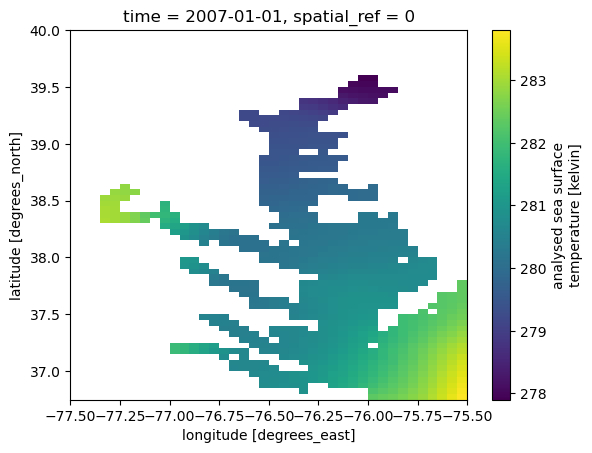

In [47]:
ds.analysed_sst.isel(time=0).plot()

## Deleware Bay

### Create geometry object used to crop out Deleware Bay

In [9]:
cbay_wkt = (
    'POLYGON ((-75.07331635657022 36.69945277755481,' 
    '-75.07331761665449 38.10656782772858, -75.37020665599995 38.29321651673962,'  
    '-75.7561692781297 39.85271304991599, -77.9036114835175 39.860284284356595,'
    '-77.9432159124284 36.7312001366339, -75.07331635657022 36.69945277755481))'
)

In [10]:
cbay_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt([cbay_wkt]), 
                            crs='EPSG:4326')

### Crop the dataset

In [11]:
clipped = ds.rio.clip(cbay_gdf.geometry.values, cbay_gdf.crs, drop=False)

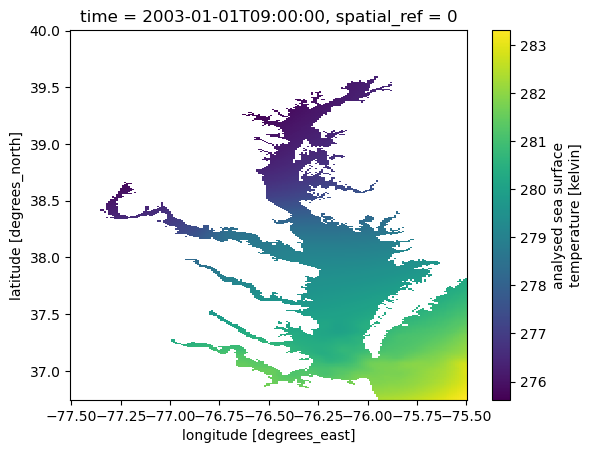

In [12]:
clipped.analysed_sst.isel(time=0).plot()

### Save

In [13]:
clipped.to_netcdf(Path('/Users/rwegener/repos/chesapeake_mhw/data/01_raw') / \
    dataset_name['MUR'][1])

## Remove Lower Tributaries

### Create geometry object used to crop out lower tributaries

In [40]:
stem_gdf = gpd.read_file(REPO_ROOT / 'data/01_raw/BayTributaryFree.geojson')

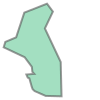

In [41]:
stem_gdf.iloc[0].geometry

### Crop the dataset

In [48]:
clipped = ds.rio.clip(stem_gdf.geometry.values, stem_gdf.crs, drop=False)

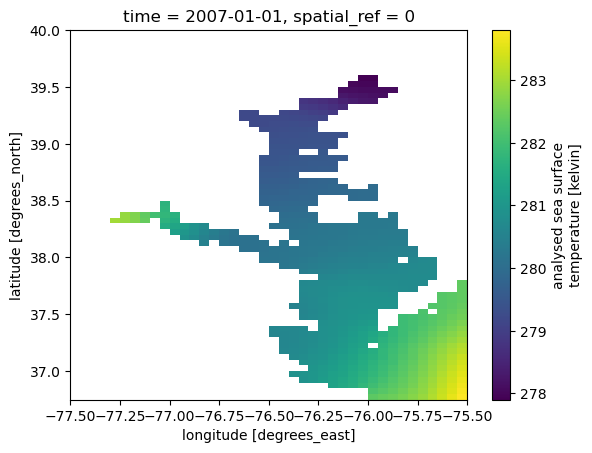

In [49]:
clipped.analysed_sst.isel(time=0).plot()

### Save

In [50]:
clipped.to_netcdf(REPO_ROOT / 'data/01_raw' / dataset_name['OSTIA'][1])

### Notes

As far as I can tell this formatting mirrors the docs exactly.

https://corteva.github.io/rioxarray/html/examples/clip_geom.html#Clip-using-a-geometry

Why doesn't it work? Github ticket or PR?

In [11]:
cbay_shape = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [-75.07331635657022, 36.69945277755481],
            [-75.07331761665449, 38.10656782772858],
            [-75.37020665599995, 38.29321651673962],
            [-75.7561692781297, 39.85271304991599],
            [-77.9036114835175, 39.860284284356595],
            [-77.9432159124284, 36.7312001366339],
            [-75.07331635657022, 36.69945277755481]
        ]]
    }
]

## Scratch

In [11]:
ds = xr.open_dataset('/Users/rwegener/repos/chesapeake_mhw/data/01_raw/L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc')

In [13]:
import pandas as pd

In [14]:
pd.date_range('2003-01-01', '2023-12-31')

DatetimeIndex(['2003-01-01', '2003-01-02', '2003-01-03', '2003-01-04',
               '2003-01-05', '2003-01-06', '2003-01-07', '2003-01-08',
               '2003-01-09', '2003-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=7670, freq='D')

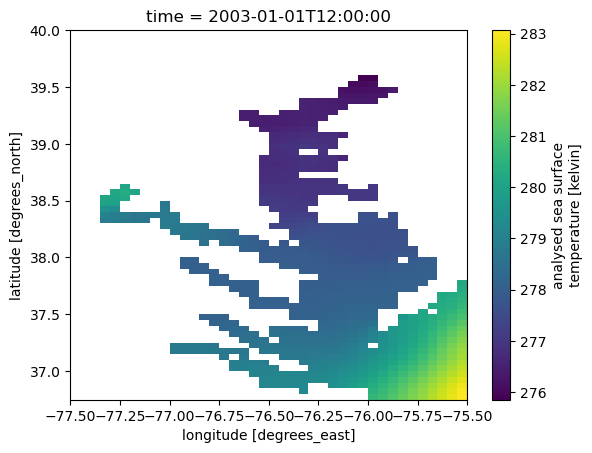

In [16]:
ds.analysed_sst.isel(time=0).plot()